In [1]:
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product
import warnings
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from tqdm import tqdm

warnings.filterwarnings('ignore')

In [2]:
def MAPE(y_true, y_pred):
    return 100*np.sum(np.abs(y_true - y_pred)/ np.abs(y_true))/len(y_true)
    

In [3]:
report = pd.read_excel('data.xlsx', sheet_name = 'Report', skiprows=1)

In [4]:
to_drop = ['Социальная сеть', 'Владелец']
report.drop(columns = to_drop, inplace = True)
report.head()

,ID поста,Текст,Эмоциональный окрас,Дата,Комментариев,Лайков,Репостов,Просмотров,Негативных комментариев,Позитивных комментариев,Нейтральных комментариев,Неопределенных комментариев,Вежливых комментариев,Юмористических комментариев
0,-159668210_25795,Нам задают много вопросов о технологическом ко...,Нейтральность,2021-12-31 07:45:00,0,0,0,3548.0,0,0,0,0,0,0
1,-74188185_20318,В высадке на Марс бизнесмен видит возможность ...,Нейтральность,2021-12-31 07:41:31,0,2,0,346.0,0,0,0,0,0,0
2,-74188185_20317,Гораздо чаще остальных американские компании и...,Нейтральность,2021-12-31 07:40:42,0,0,0,319.0,0,0,0,0,0,0
3,-21732035_11926,"Twitter-аккаунт, который ранее связывали с защ...",Негатив,2021-12-31 07:23:16,0,2,0,222.0,0,0,0,0,0,0
4,-718901_3742,Дорогие коллеги и друзья! \n⠀ \nСпасибо за ваш...,Позитив,2021-12-31 07:13:35,0,37,2,3956.0,0,0,0,0,0,0


# TimeSeries

In [5]:
TS = report[['Дата', 'Просмотров']]
TS['Дата'] = pd.to_datetime(TS['Дата'])

In [6]:
TS['Дата']= pd.to_datetime(TS['Дата'], unit="day")
TS['Дата'] = TS['Дата'].values.astype('datetime64[D]')

In [8]:
TS_day_drop = TS.dropna()

In [9]:
time_series = TS_day_drop.groupby( [TS_day_drop.Дата.dt.date] )['Просмотров'].sum()

time_series = time_series.to_frame()

time_series.index = pd.to_datetime(time_series.index)

## Визуальный анализ ряда

Критерий Дики-Фуллера: p=0.297890


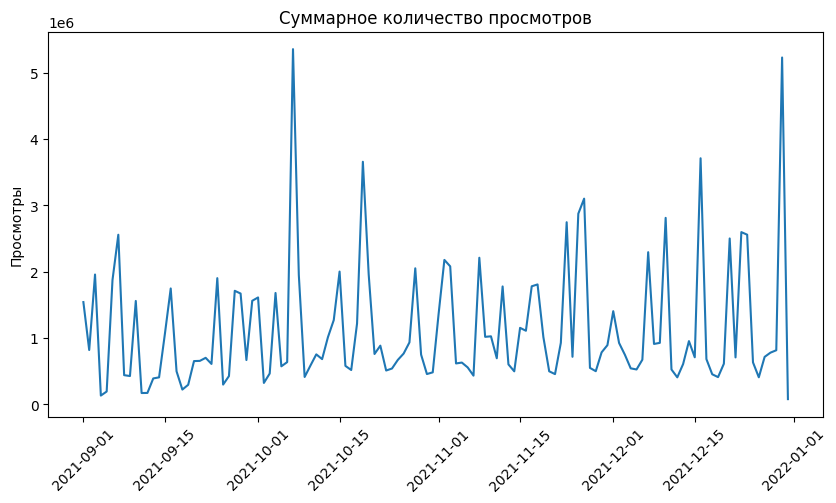

In [111]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(time_series)[1])
plt.figure(figsize=(10, 5))
plt.plot(time_series)
plt.title('Cуммарное количество просмотров')
plt.ylabel('Просмотры')
plt.tick_params(axis = 'x' , labelrotation = 45)
plt.show();

Критерий Дики-Фуллера: p=0.121918


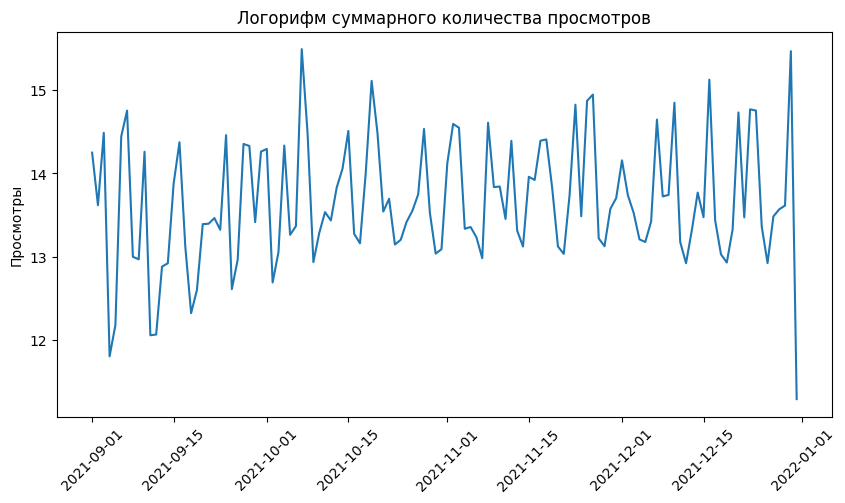

In [116]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(np.log(time_series))[1])
plt.figure(figsize=(10,5))
plt.plot(np.log(time_series))
plt.title('Логорифм суммарного количества просмотров')
plt.ylabel('Просмотры')
plt.tick_params(axis = 'x' , labelrotation = 45)
plt.show()

# Выбор начальных приближений для p, q
q - номер последнего несезонного лага, при котом автокорреляция значима

p - номер последнего несезонного лага, при котом частичная автокорреляция значима

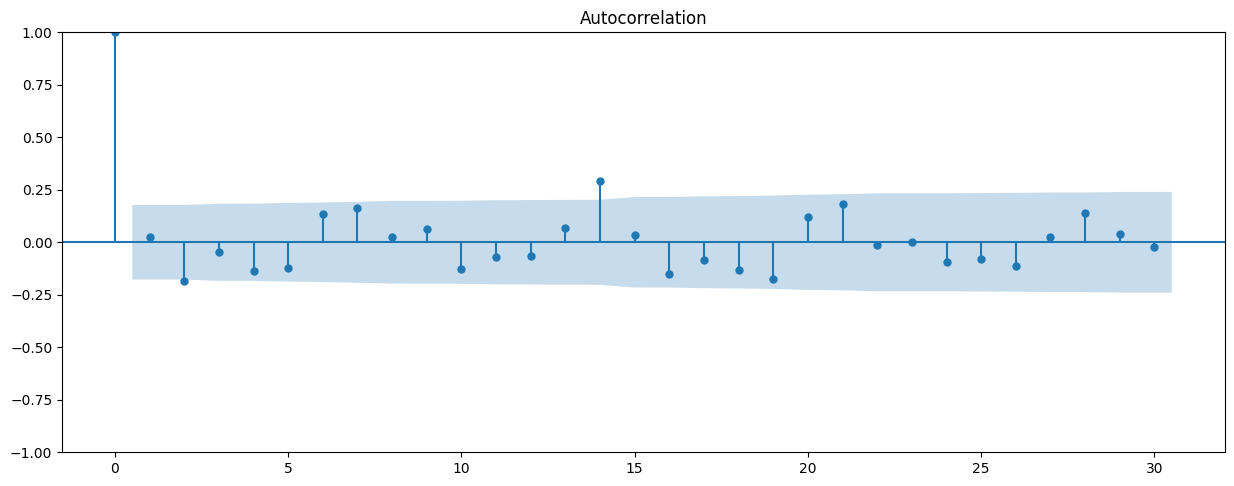

C:\Users\Максим\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


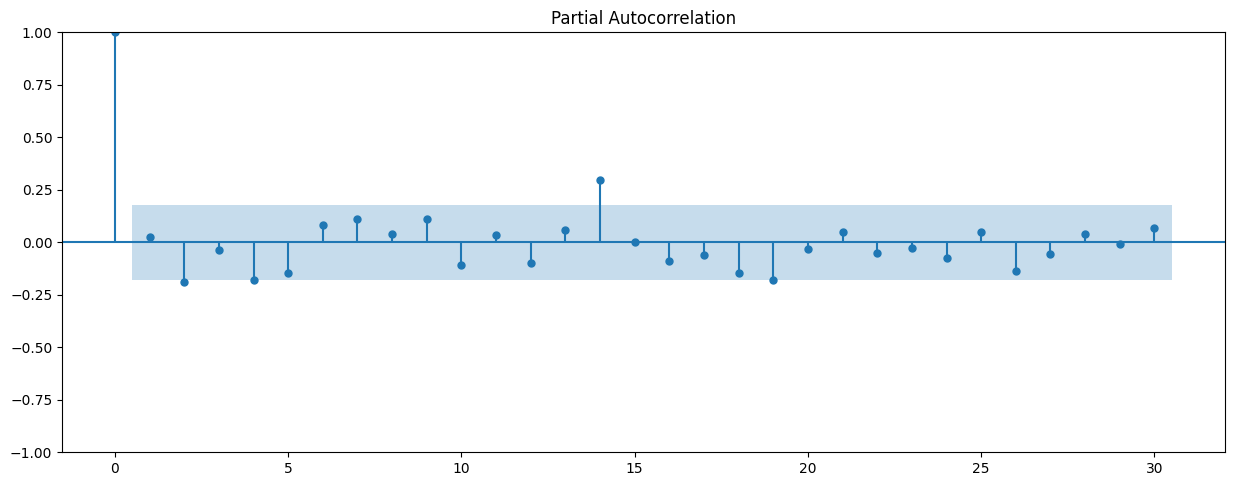

In [124]:
plt.figure(figsize = (15,12))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(time_series.values.squeeze(), lags=30, ax=ax)
plt.show();

plt.figure(figsize = (15,12))
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(time_series.values.squeeze(), lags=30, ax=ax)
plt.show();

In [94]:
ps = range(0, 16)
d = range(1, 2)
qs = range(0, 16)


parameters = product(ps,d, qs)
parameters_list = list(parameters)
len(parameters_list)

256

# ARIMA

In [95]:
TRAIN, TEST = train_test_split( time_series, test_size=0.2, random_state=42, shuffle = False)

In [96]:
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in tqdm(parameters_list):
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.arima.ARIMA(np.log(TRAIN.Просмотров), order=(param[0], param[1], param[2]), 
                                        ).fit()
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

100%|████████████████████████████████████████████████████████████████████████████████| 256/256 [04:34<00:00,  1.07s/it]


In [97]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

    parameters         aic
71   (4, 1, 7)  185.493633
84   (5, 1, 4)  187.378407
86   (5, 1, 6)  187.396877
90  (5, 1, 10)  187.398016
89   (5, 1, 9)  187.428385


In [98]:
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:             Просмотров   No. Observations:                   97
Model:                 ARIMA(4, 1, 7)   Log Likelihood                 -80.747
Date:                Thu, 16 Mar 2023   AIC                            185.494
Time:                        23:29:33   BIC                            216.266
Sample:                    09-01-2021   HQIC                           197.932
                         - 12-06-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8147      0.047     17.511      0.000       0.724       0.906
ar.L2         -1.4354      0.051    -27.925      0.000      -1.536      -1.335
ar.L3          0.7870      0.050     15.701      0.0

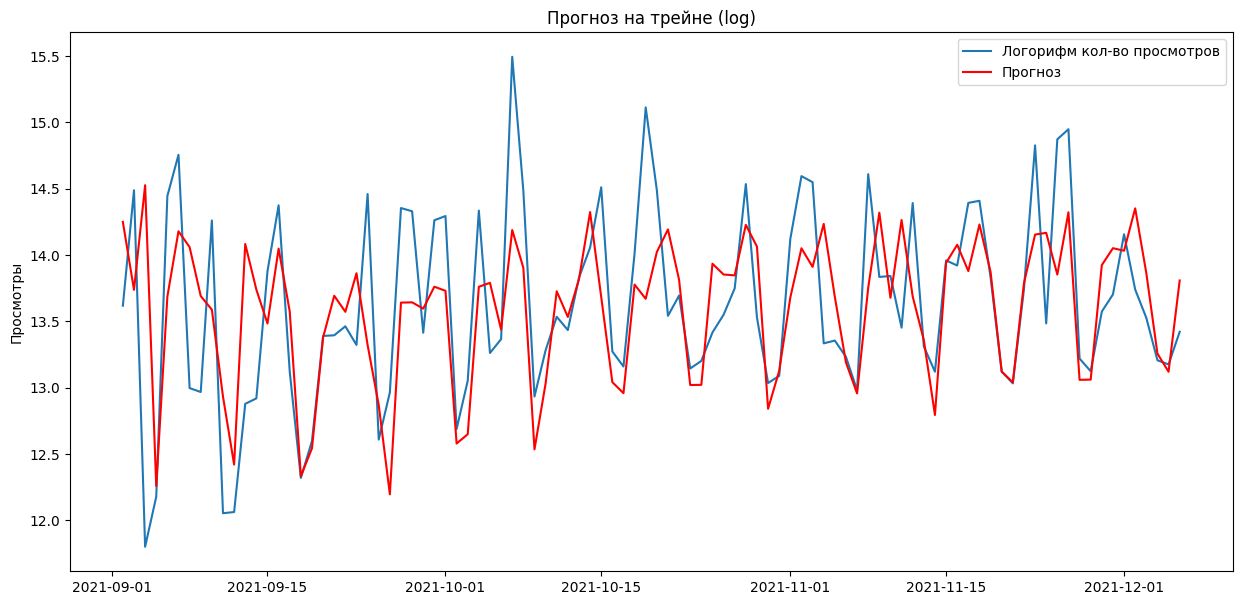

In [127]:
pred = best_model.fittedvalues
plt.figure(figsize = (15,7))
plt.plot(np.log(time_series.Просмотров)[1:len(pred)], label = 'Логорифм кол-во просмотров')
plt.plot(pred[1:], color='r', label = 'Прогноз')
plt.ylabel('Просмотры')
plt.legend()
plt.title('Прогноз на трейне (log)')
plt.show()

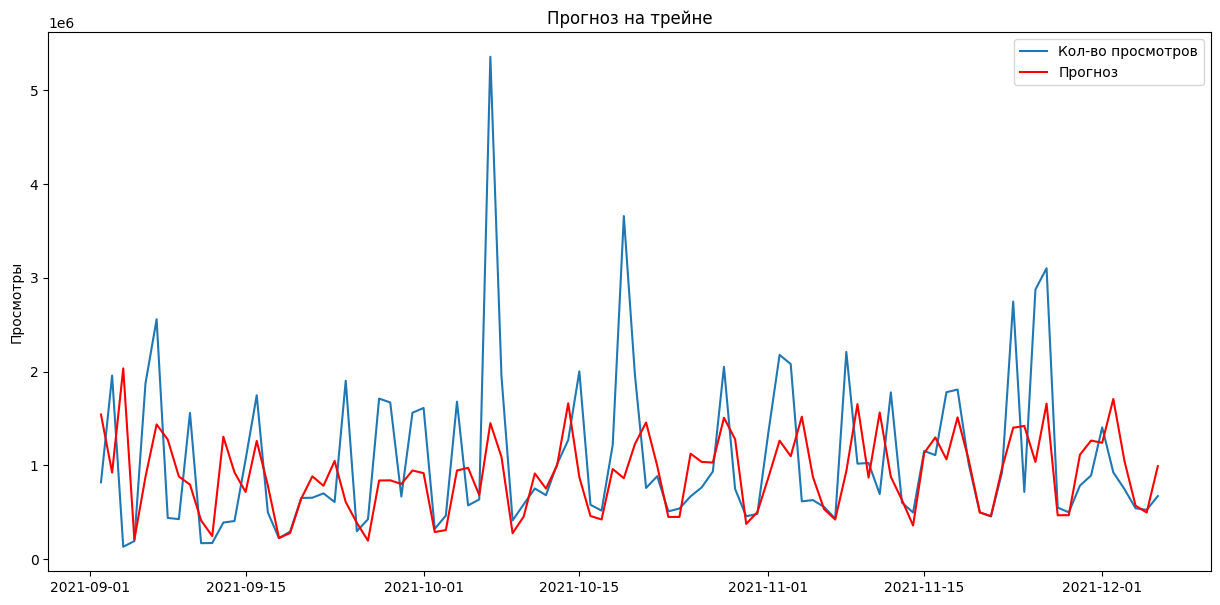

In [126]:
pred = best_model.fittedvalues #invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize = (15,7))
plt.plot(time_series.Просмотров[1:len(pred)], label = 'Кол-во просмотров')
plt.plot(np.exp(pred)[1:], color='r', label = 'Прогноз')
plt.ylabel('Просмотры')
plt.title('Прогноз на трейне')
plt.legend()
plt.show()

In [101]:
time_series[time_series.Просмотров>3e6]

,Просмотров
Дата,
2021-10-07,5356237.0
2021-10-19,3658311.0
2021-11-26,3102422.0
2021-12-16,3710898.0
2021-12-30,5230248.0


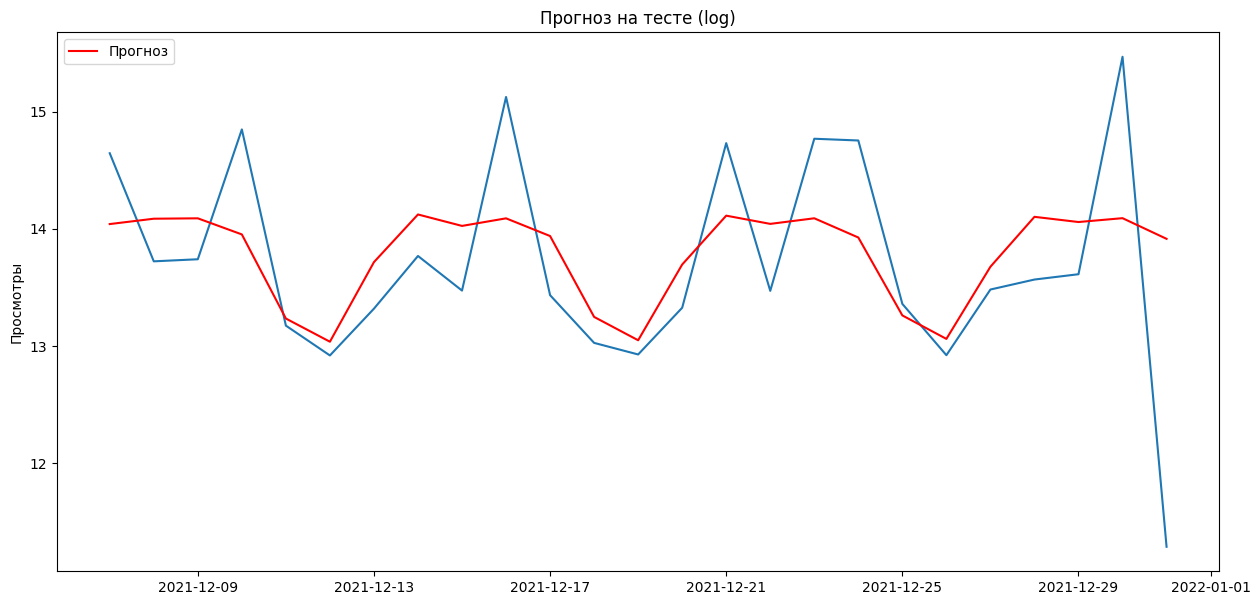

In [123]:
pred = best_model.predict(start=97, end=121)
plt.figure(figsize = (15,7))
plt.plot(np.log(TEST))
plt.plot(pred, color='r', label = 'Прогноз')
plt.ylabel('Просмотры')
plt.title('Прогноз на тесте (log)')
plt.legend()
plt.show()

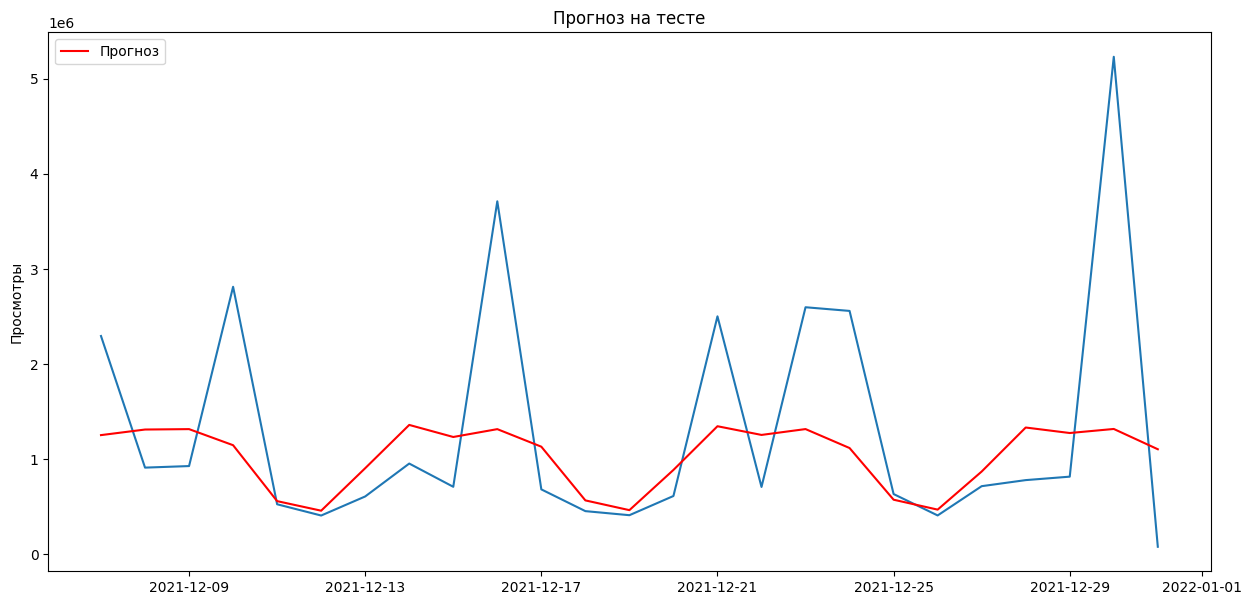

In [132]:
pred = best_model.predict(start=97, end=121)
plt.figure(figsize = (15,7))
plt.plot(TEST)
plt.plot(np.exp(pred), color='r', label = 'Прогноз')
plt.ylabel('Просмотры')
plt.title('Прогноз на тесте')
plt.legend()
plt.show()

In [133]:
MAPE(np.log(TEST.Просмотров), pred)

4.150659770637458

In [134]:
MAPE(TEST.Просмотров, np.exp(pred))

94.01179538098204

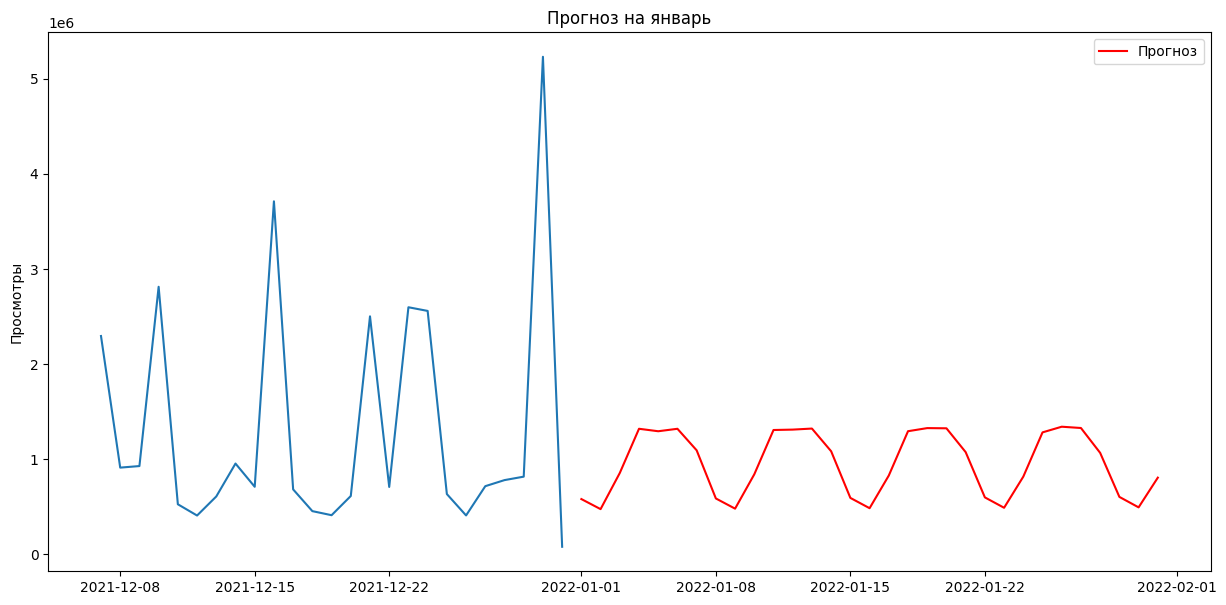

In [140]:
pred = best_model.predict(start=122, end=121+31)

plt.figure(figsize = (15,7))
plt.plot(TEST)
plt.plot(np.exp(pred), color='r', label = 'Прогноз')
plt.ylabel('Просмотры')
plt.title('Прогноз на январь')
plt.legend()
plt.show()

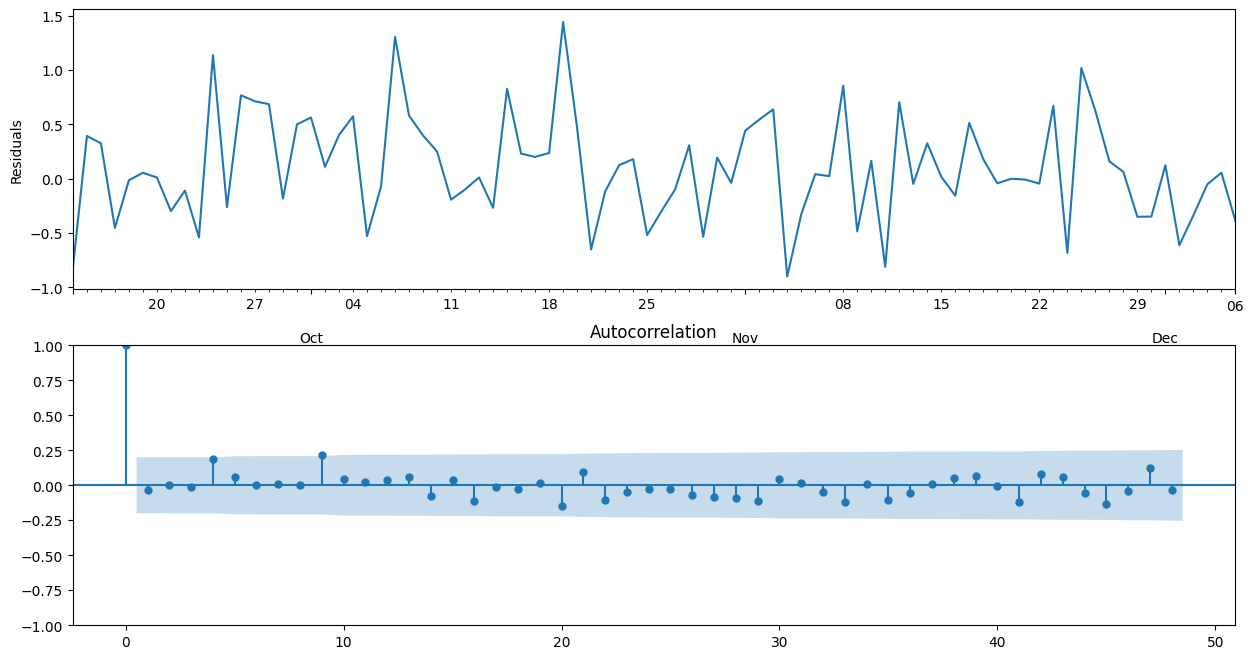

Критерий Дики-Фуллера: p=0.000000


In [141]:
plt.figure(figsize = (15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[1:].values.squeeze(), lags=48, ax=ax)
plt.show()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

In [180]:
sub = pd.DataFrame(np.exp(pred))
sub.head()

,predicted_mean
2022-01-01,5.811843e+05
2022-01-02,4.754123e+05
2022-01-03,8.554216e+05
2022-01-04,1.320035e+06
2022-01-05,1.294069e+06


In [181]:
sub = sub.reset_index()
sub.head()

,index,predicted_mean
0,2022-01-01,5.811843e+05
1,2022-01-02,4.754123e+05
2,2022-01-03,8.554216e+05
3,2022-01-04,1.320035e+06
4,2022-01-05,1.294069e+06


In [182]:
sub.to_csv('ts.csv', index = False)

Проверим гипотезу о нормальности остатков.

In [107]:
import scipy.stats
scipy.stats.shapiro(best_model.resid[1:].values.squeeze())[1]

0.0011025533312931657

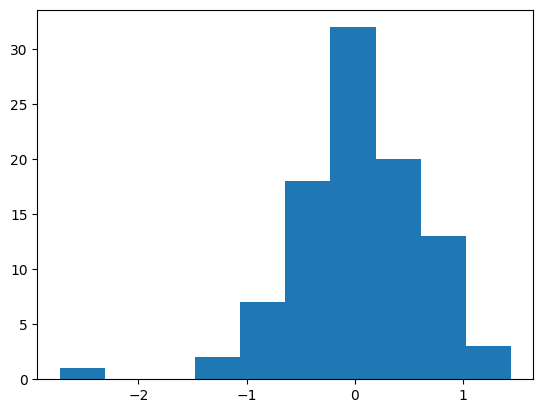

In [108]:
plt.hist(best_model.resid[1:].values.squeeze());

**Т.к p_value <= 0.05 мы отвергаем нулевую гипотезу о том, что ошибки рапределены нормально.**

Проверим гипотезу о несмещённости остатков H0 : ε = 0 можно формально проверить с помощью какого-либо стандартного одновыборочного критерия, например с помощью критерия Стьюдента или Уилкоксона.

In [109]:
print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])

Критерий Стьюдента: p=0.059269


**Т.к p_value > 0.05 нулевая гипотеза H0 : ε = 0 не отвергается.**